In [10]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import time
import torch
from torch_geometric.loader import DataLoader
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
# from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
%matplotlib notebook
import copy

import time
import torch
from torch_geometric.loader import DataLoader
from tqdm.notebook import trange, tqdm
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))


import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

seed = 0


import random 
import numpy as np
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
# print(torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('running on: ', device)
torch.set_num_threads(1)

from joblib import Parallel, delayed

from cutlass import *
from rbfConv import *
from tqdm.notebook import tqdm

from datautils import *
# from sphUtils import *
from lossFunctions import *

In [11]:

from plotting import *
plt.style.use('dark_background')
# plt.style.use('default')
from tqdm.notebook import trange, tqdm

In [12]:
# import itertools
# from itertools import permutations

# options_x = ['rbf square', 'rbf linear', 'rbf bump', 'rbf spiky', 'rbf cubic_spline', 'rbf gaussian', 'fourier', 'chebyshev']
# options_y = options_x

# options_x = ['-x chebyshev -y chebyshev', '-x chebyshev -y fourier', '-x linear -y linear', '-x "rbf cubic_spline" -y "rbf cubic_spline"', '-x "rbf gaussian" -y "rbf gaussian"']
# options_y = ['-cmap cartesian', '-cmap polar', '-cmap preserving']

# options_x = ['-n 2 -m 2','-n 4 -m 4','-n 5 -m 5','-n 9 -m 9','-n 15 -m 15','-n 31 -m 31']
# options_y = ['-w "Wendland2"','-w "Wendland2_1D"','-w "Wendland4"','-w "cubicSpline"','-w "none"','-w "none"','-w "none"']

# combinations = []

# for x in options_x:
#     for y in options_y:
#         combinations.append((x,y))

    
# # debugPrint(len(combinations))


# for x,y in combinations:
#     print("clear && python densityNetTraining.py --epochs=25 -n 9 -m 9 -w 'none' %s %s" % ( x,y))

In [13]:
from datautils import *

In [14]:
basePath = '~/dev/datasets/generative2D/train'
basePath = os.path.expanduser(basePath)

simulationFiles = [basePath + '/' + f for f in os.listdir(basePath) if f.endswith('.hdf5')]
debugPrint(simulationFiles)

simulationFiles [list] = ['/home/winchenbach/dev/datasets/generative2D/train/generative - 2023-03-13_10-01-01.hdf5', '/home/winchenbach/dev/datasets/generative2D/train/generative - 2023-03-13_10-16-02.hdf5', '/home/winchenbach/dev/datasets/generative2D/train/generative - 2023-03-13_10-05-55.hdf5', '/home/winchenbach/dev/datasets/generative2D/train/generative - 2023-03-13_10-36-42.hdf5', '/home/winchenbach/dev/datasets/generative2D/train/generative - 2023-03-13_10-23-46.hdf5', '/home/winchenbach/dev/datasets/generative2D/train/generative - 2023-03-13_10-28-47.hdf5', '/home/winchenbach/dev/datasets/generative2D/train/generative - 2023-03-13_10-10-55.hdf5', '/home/winchenbach/dev/datasets/generative2D/train/generative - 2023-03-13_10-18-34.hdf5', '/home/winchenbach/dev/datasets/generative2D/train/generative - 2023-03-13_10-21-09.hdf5', '/home/winchenbach/dev/datasets/generative2D/train/generative - 2023-03-13_10-03-31.hdf5', '/home/winchenbach/dev/datasets/generative2D/train/generative - 

In [18]:
trainFolder = '~/servus05/dev/torchSPH2/Cconv/trainingData'
trainFolder = os.path.expanduser(trainFolder)
subfolders = [ f.path for f in os.scandir(trainFolder) if f.is_dir() ]
# subfolders = [ f.path for f in os.scandir('./trainingDataBasisFunctions8x8') if f.is_dir() ]
print(len(subfolders))

subfolders = [s for s in subfolders if os.path.exists(s + '/results.json')]
print(len(subfolders))

62
60


In [19]:
which_x = 'n'
which_y = 'arch'
which_z = 'frameDistance'

In [20]:
dataDict = {}

subfolders[0]
for s in subfolders:
    with open("%s/results.json" % s, "r") as read_file:
        decodedArray = json.load(read_file)
        dataDict[s] = decodedArray
#         print(decodedArray['hyperParameters'])   

In [34]:
print(dataDict[subfolders[0]].keys())

dict_keys(['hyperParameters', 'dataSet', 'epochData', 'files'])


In [29]:
trainingLosses = {}
validationLosses = {}
for s in subfolders:
    trainingEpochLosses = [np.asarray(dataDict[s]['epochData'][k]['training']) for k in dataDict[s]['epochData'].keys()]
    validationEpochLosses = [np.asarray(dataDict[s]['epochData'][k]['validation']) for k in dataDict[s]['epochData'].keys()]
    trainingLosses[s] = trainingEpochLosses
    validationLosses[s] = validationEpochLosses
debugPrint(trainingLosses)

trainingLosses [dict] = {'/home/winchenbach/servus05/dev/torchSPH2/Cconv/trainingData/generative2D - n=[ 2, 2] rbf=[linear,linear] map = preserving window = poly6 d =  4 e = 10 arch 8 16 16 3 distance =  4 - 2023-03-14_07-00-02': [], '/home/winchenbach/servus05/dev/torchSPH2/Cconv/trainingData/generative2D - n=[ 8, 8] rbf=[linear,linear] map = preserving window = poly6 d =  2 e = 10 arch 16 32 32 3 distance =  2 - 2023-03-14_05-33-32': [], '/home/winchenbach/servus05/dev/torchSPH2/Cconv/trainingData/generative2D - n=[ 2, 2] rbf=[linear,linear] map = preserving window = poly6 d =  1 e = 10 arch 16 32 32 3 distance =  1 - 2023-03-13_23-59-23': [], '/home/winchenbach/servus05/dev/torchSPH2/Cconv/trainingData/generative2D - n=[ 4, 4] rbf=[linear,linear] map = preserving window = poly6 d =  2 e = 10 arch 8 16 16 3 distance =  2 - 2023-03-14_04-44-46': [], '/home/winchenbach/servus05/dev/torchSPH2/Cconv/trainingData/generative2D - n=[ 4, 4] rbf=[linear,linear] map = preserving window = poly6

In [22]:
def plotKDEs(trainingEpochLosses, label = None):
    overallLosses = np.vstack([np.expand_dims(np.vstack((np.mean(e[:,:,0], axis = 1), np.max(e[:,:,1], axis = 1), np.min(e[:,:,2], axis = 1) , np.mean(e[:,:,3], axis = 1))),2).T for e in trainingEpochLosses])
    fig, axis = plt.subplots(1, 3, figsize=(16,5), sharex = False, sharey = False, squeeze = False)
    if label is not None:
        fig.suptitle(label)

    plt.sca(axis[0,0])
    axis[0,0].set_title('Mean Loss')
    axis[0,1].set_title('Max Loss')
    axis[0,2].set_title('Std dev Loss')


    for ei in range(overallLosses.shape[0]):
        plt.sca(axis[0,0])
        sns.kdeplot(overallLosses[ei,:,0], bw_adjust=.2, log_scale=True, label = 'epoch: %2d' % ei, c = cm.viridis(ei / ( overallLosses.shape[0] - 1)))
        plt.sca(axis[0,1])
        sns.kdeplot(overallLosses[ei,:,1], bw_adjust=.2, log_scale=True, label = 'epoch: %2d' % ei, c = cm.viridis(ei / ( overallLosses.shape[0] - 1)))
        plt.sca(axis[0,2])
        sns.kdeplot(overallLosses[ei,:,3], bw_adjust=.2, log_scale=True, label = 'epoch: %2d' % ei, c = cm.viridis(ei / ( overallLosses.shape[0] - 1)))

    fig.tight_layout()
# fig.savefig('./trainingData/%s/training_kde.png' % exportString, dpi = 300)


In [23]:
import seaborn as sns

In [28]:
xvars = []
yvars = []
zvars = []
for s in subfolders:
    xv = dataDict[s]['hyperParameters'][which_x]
    if xv not in xvars:
        xvars.append(xv)
    yv = dataDict[s]['hyperParameters'][which_y]
    if yv not in yvars:
        yvars.append(yv)
    zv = dataDict[s]['hyperParameters'][which_z]
    if zv not in zvars:
        zvars.append(zv)
debugPrint(xvars)
debugPrint(yvars)
debugPrint(zvars)
xvars.sort()
yvars.sort()
zvars.sort()

xvars [list] = [2, 8, 4]
yvars [list] = ['8 16 16 3', '16 32 32 3', '32 64 64 3', '4 8 8 3', '4 8 8 8 3', '4 8 8 8 8 3', '8 16 16 8 8 3']
zvars [list] = [4, 2, 1]


<IPython.core.display.Javascript object>


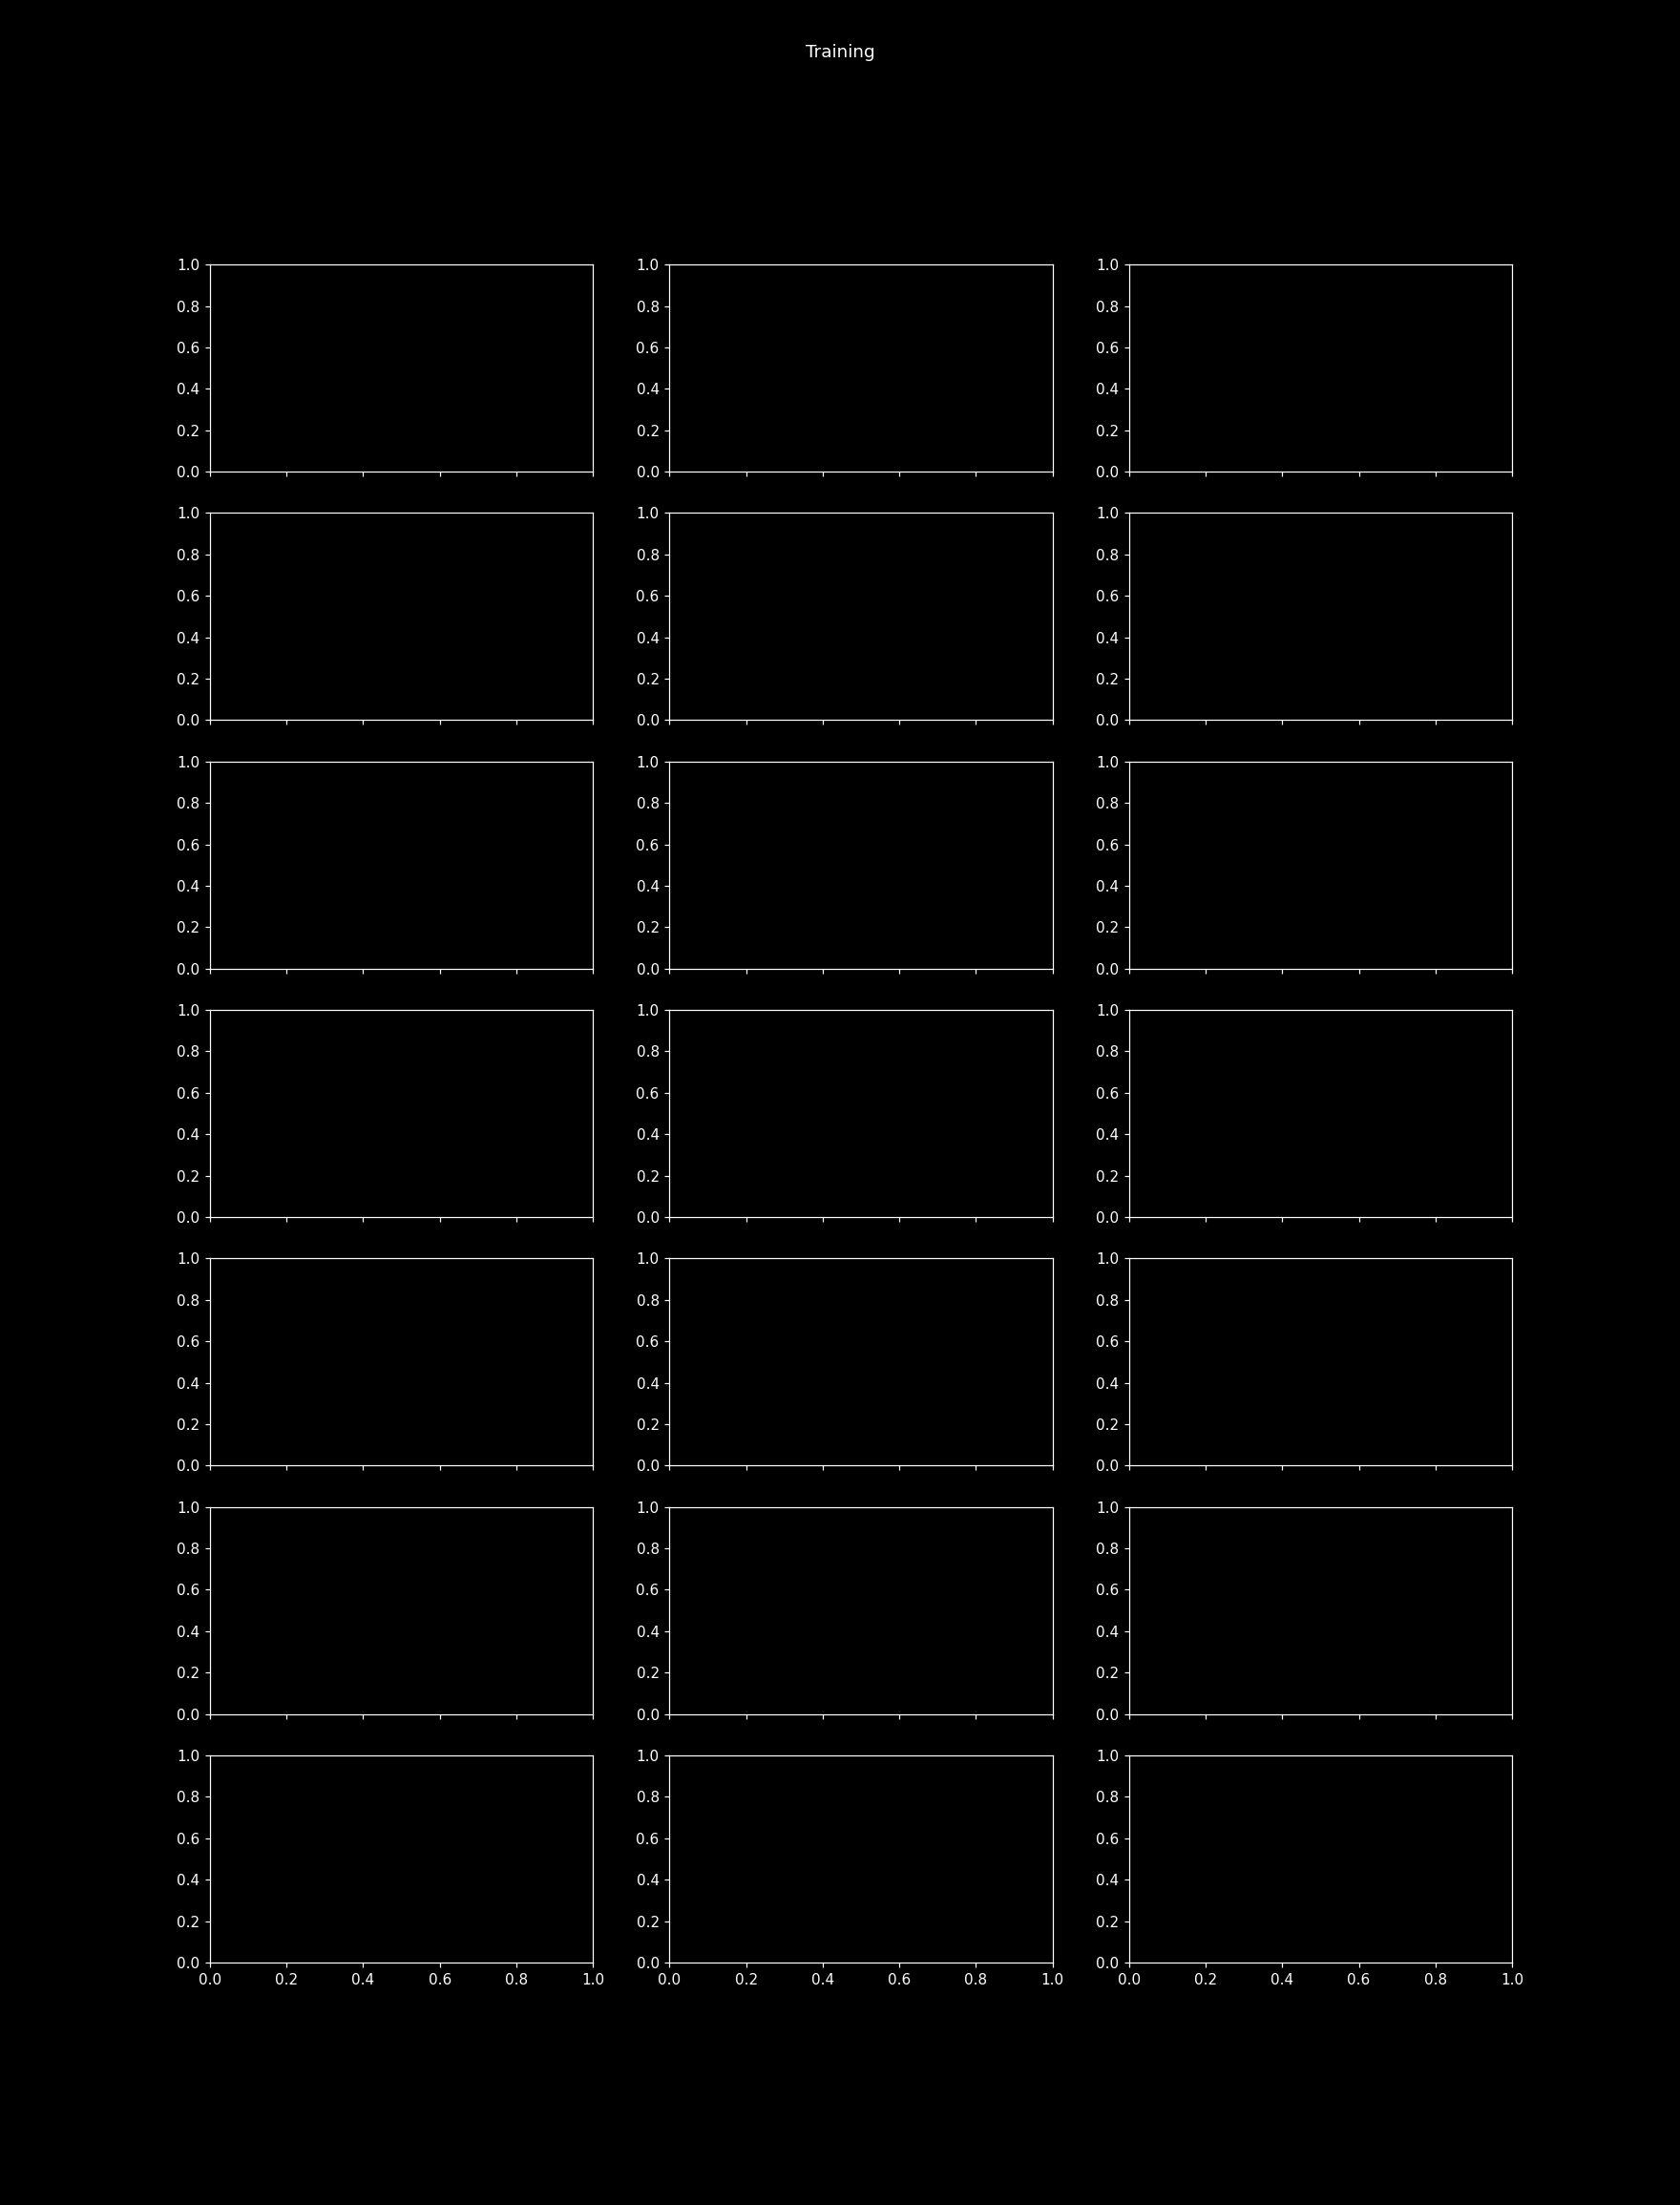

ValueError: need at least one array to concatenate

In [25]:
trainingEpochLosses = trainingLosses[subfolders[0]]
fig, axis = plt.subplots(len(yvars), 3, figsize=(16,3 * len(yvars)), sharex = True, sharey = False, squeeze = False)

# for y in yvars:
fig.suptitle('Training')

losses = {}
for s in subfolders:
    trainingEpochLosses = trainingLosses[s]
    overallLosses = np.vstack([np.expand_dims(np.vstack((np.mean(e[:,:,0], axis = 1), np.max(e[:,:,1], axis = 1), np.min(e[:,:,2], axis = 1) , np.mean(e[:,:,3], axis = 1))),2).T for e in trainingEpochLosses])
    losses[s] = overallLosses

epoch = -1

def plot_func(epoch):    
    plt.sca(axis[0,0])
    for i in range(len(yvars)):
        for j in range(3):        
            axis[i,j].cla()
#             plt.sca(axis[i,j])
        axis[i,0].set_title('Mean Loss')
        axis[i,1].set_title('Max Loss')
        axis[i,2].set_title('Std dev Loss')

    cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for s in subfolders:
        c = xvars.index(dataDict[s]['hyperParameters'][which_x])
        r = yvars.index(dataDict[s]['hyperParameters'][which_y])
        plt.sca(axis[r,0])
        sns.kdeplot(losses[s][epoch,:,0], bw_adjust=.2, log_scale=True, label = 'epoch: %2d' % epoch, c = cols[c % len(cols)])
        plt.sca(axis[r,1])
        sns.kdeplot(losses[s][epoch,:,1], bw_adjust=.2, log_scale=True, label = 'epoch: %2d' % epoch, c = cols[c % len(cols)])
        plt.sca(axis[r,2])
        sns.kdeplot(losses[s][epoch,:,3], bw_adjust=.2, log_scale=True, label = '[%s = %s x %s = %s]' % (which_x, dataDict[s]['hyperParameters'][which_x], which_y, dataDict[s]['hyperParameters'][which_y]), c = cols[c % len(cols)])
        axis[r,2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    for c in range(len(yvars)):
        handles, labels = axis[c,2].get_legend_handles_labels()
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        axis[c,2].legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

    fig.canvas.draw_idle()

epochs = dataDict[subfolders[0]]['hyperParameters']['epochs']
interact(plot_func, epoch = widgets.IntSlider(value=epochs -1, min=0, max=epochs -1, step=1))

fig.tight_layout()


<IPython.core.display.Javascript object>


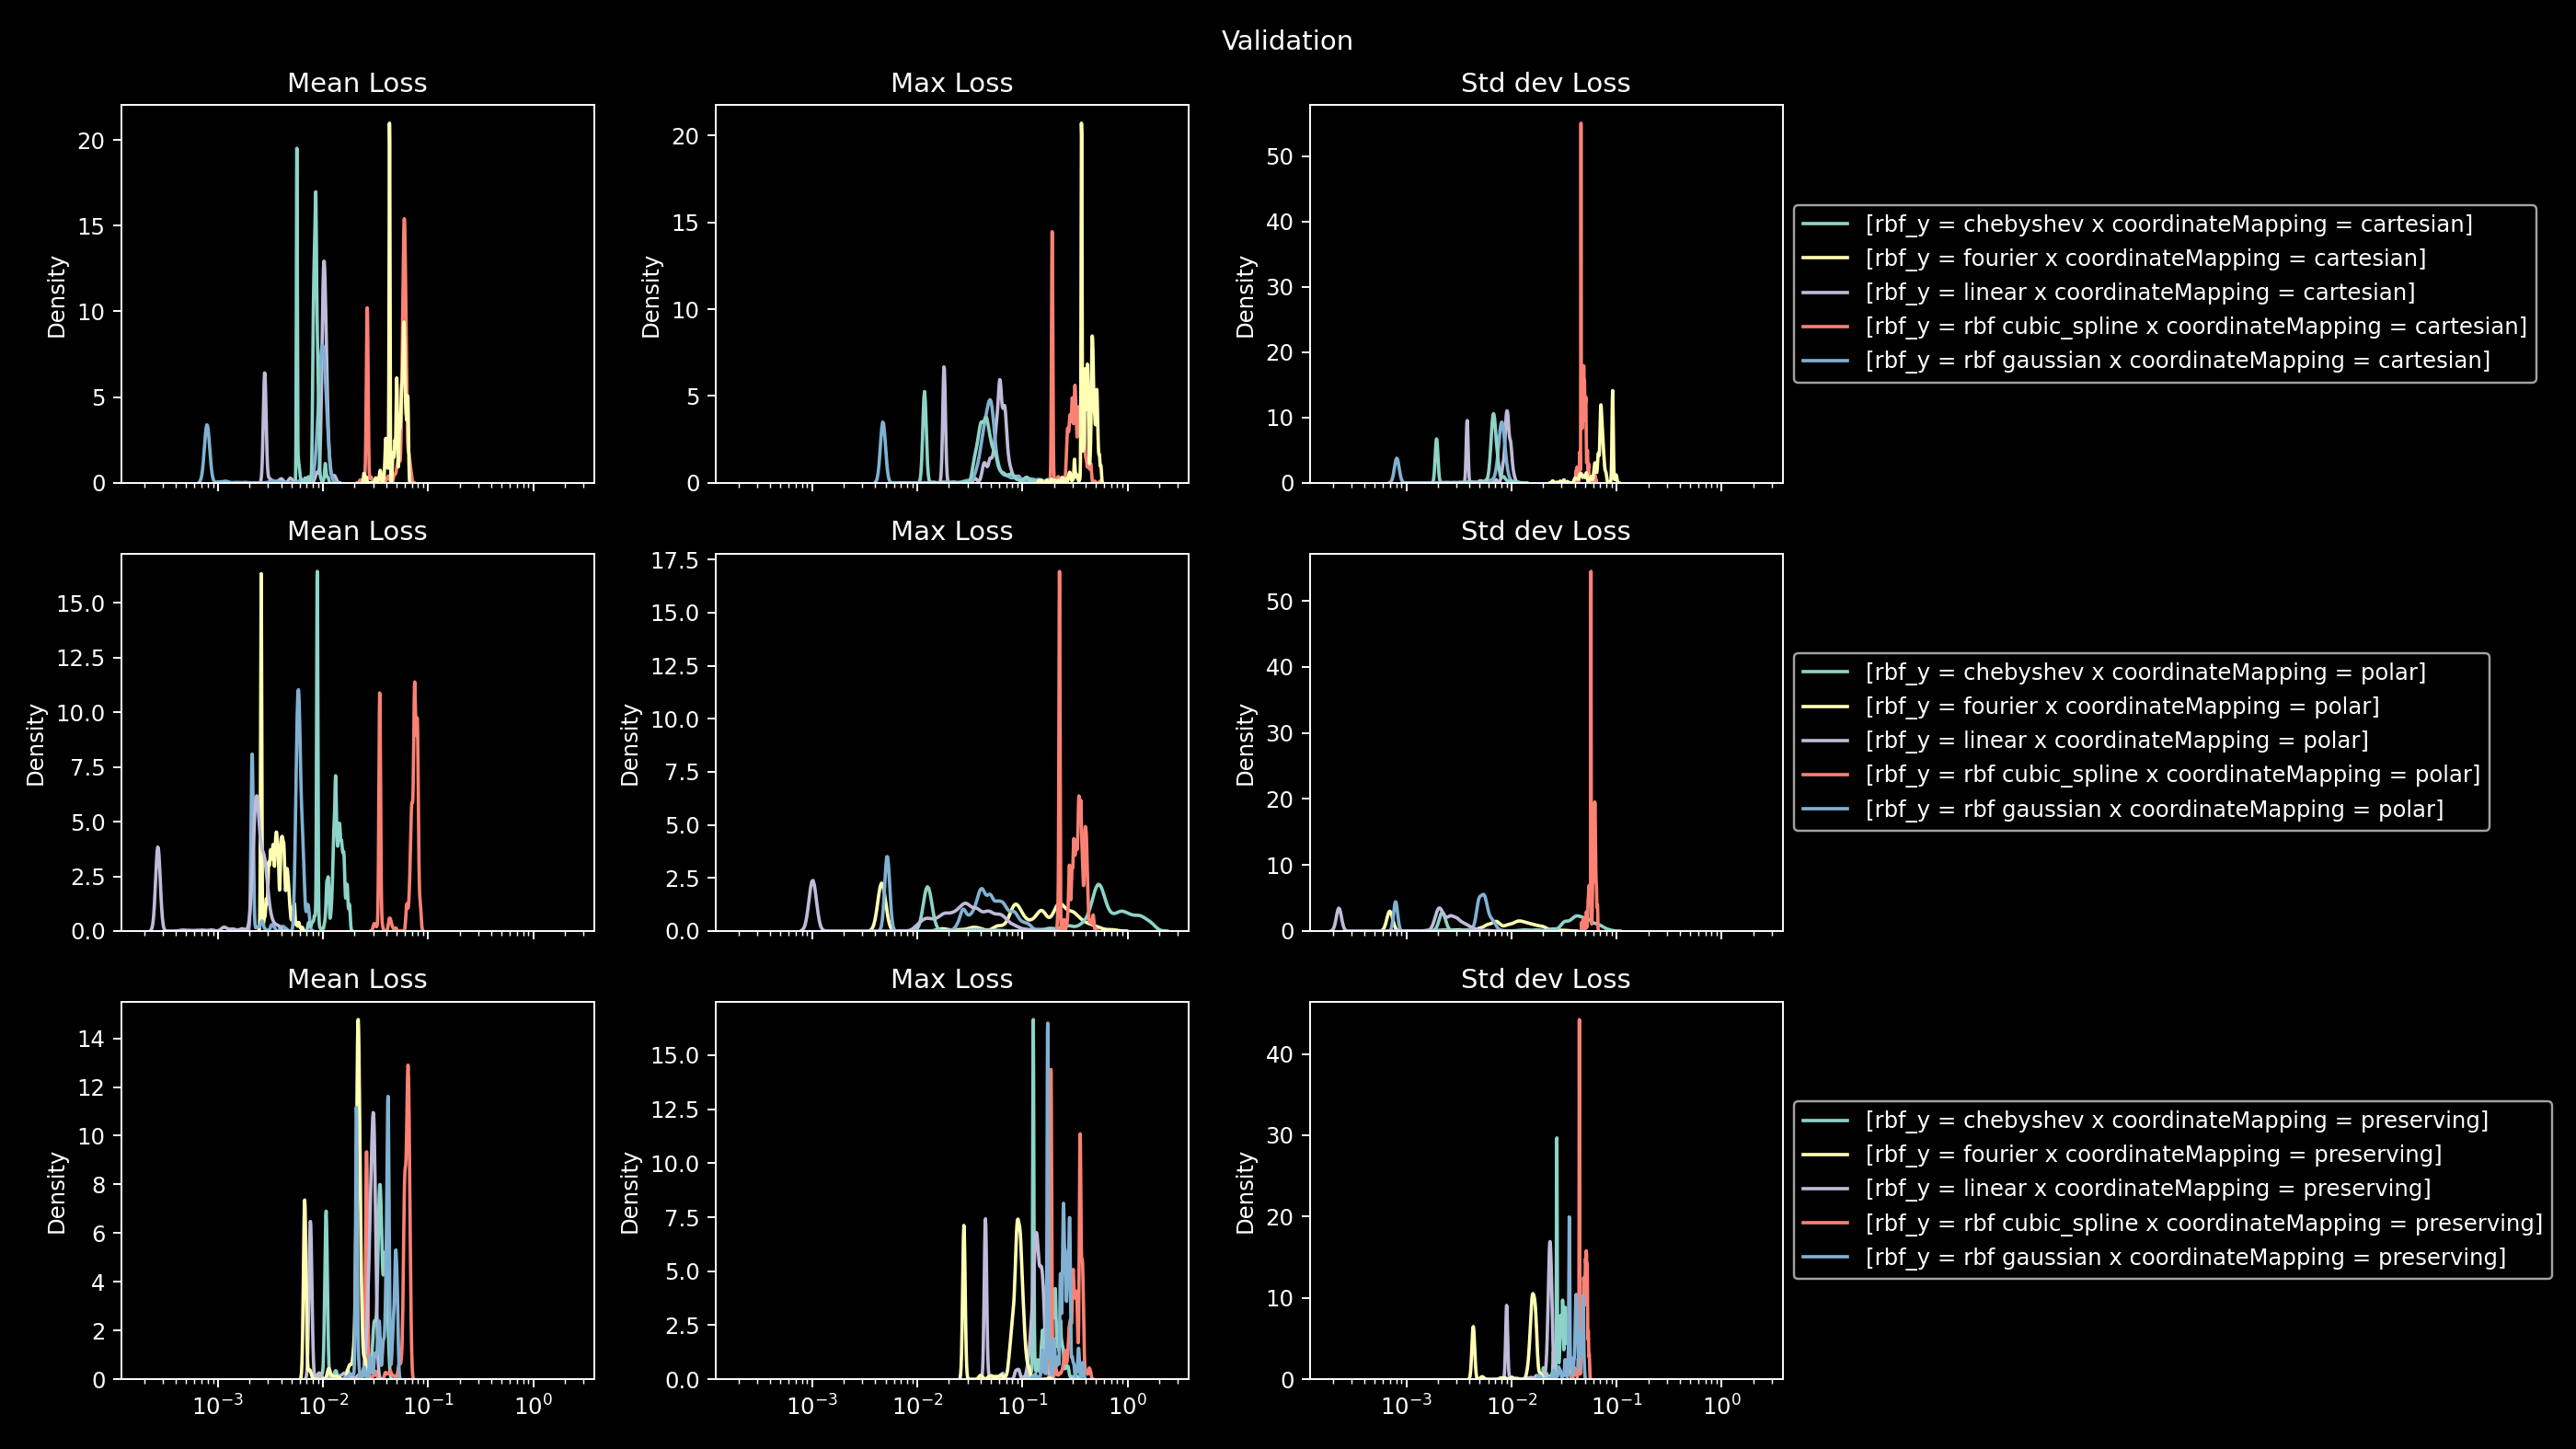

interactive(children=(IntSlider(value=24, description='epoch', max=24), Output()), _dom_classes=('widget-inter…

In [124]:
trainingEpochLosses = trainingLosses[subfolders[0]]
fig, axis = plt.subplots(len(yvars), 3, figsize=(16,3 * len(yvars)), sharex = True, sharey = False, squeeze = False)

# for y in yvars:
fig.suptitle('Validation')

losses = {}
for s in subfolders:
    trainingEpochLosses = validationLosses[s]
    overallLosses = np.vstack([np.expand_dims(np.vstack((np.mean(e[:,:,0], axis = 1), np.max(e[:,:,1], axis = 1), np.min(e[:,:,2], axis = 1) , np.mean(e[:,:,3], axis = 1))),2).T for e in trainingEpochLosses])
    losses[s] = overallLosses

epoch = -1

def plot_func(epoch):    
    plt.sca(axis[0,0])
    for i in range(len(yvars)):
        for j in range(3):        
            axis[i,j].cla()
#             plt.sca(axis[i,j])
        axis[i,0].set_title('Mean Loss')
        axis[i,1].set_title('Max Loss')
        axis[i,2].set_title('Std dev Loss')

    cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for s in subfolders:
        c = xvars.index(dataDict[s]['hyperParameters'][which_x])
        r = yvars.index(dataDict[s]['hyperParameters'][which_y])
        plt.sca(axis[r,0])
        sns.kdeplot(losses[s][epoch,:,0], bw_adjust=.2, log_scale=True, label = 'epoch: %2d' % epoch, c = cols[c % len(cols)])
        plt.sca(axis[r,1])
        sns.kdeplot(losses[s][epoch,:,1], bw_adjust=.2, log_scale=True, label = 'epoch: %2d' % epoch, c = cols[c % len(cols)])
        plt.sca(axis[r,2])
        sns.kdeplot(losses[s][epoch,:,3], bw_adjust=.2, log_scale=True, label = '[%s = %s x %s = %s]' % (which_x, dataDict[s]['hyperParameters'][which_x], which_y, dataDict[s]['hyperParameters'][which_y]), c = cols[c % len(cols)])
        axis[r,2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    for c in range(len(yvars)):
        handles, labels = axis[c,2].get_legend_handles_labels()
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        axis[c,2].legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

    fig.canvas.draw_idle()

epochs = dataDict[subfolders[0]]['hyperParameters']['epochs']
interact(plot_func, epoch = widgets.IntSlider(value=epochs -1, min=0, max=epochs -1, step=1))

fig.tight_layout()


In [86]:

import matplotlib.patheffects as path_effects

<IPython.core.display.Javascript object>


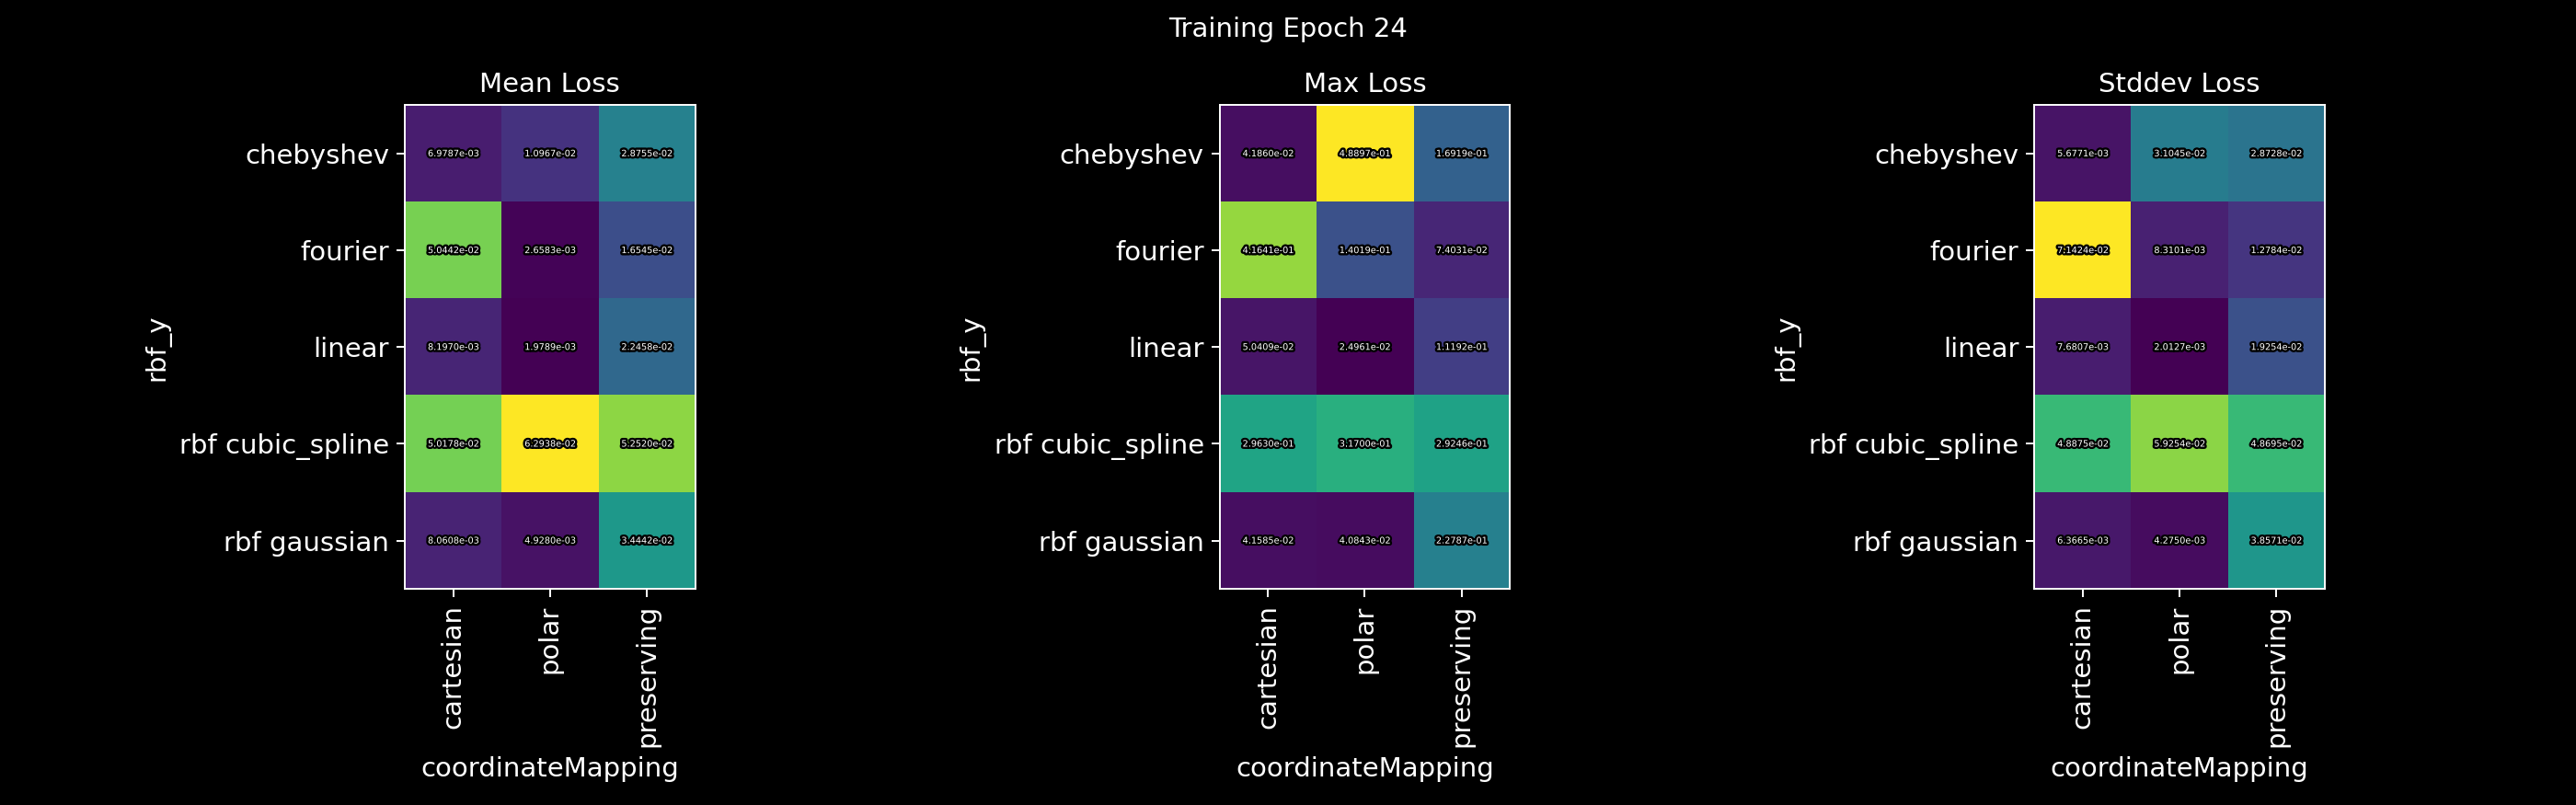

interactive(children=(IntSlider(value=24, description='epoch', max=24), Output()), _dom_classes=('widget-inter…

<function __main__.plot_func(epoch)>

In [89]:
def plotToAxis(axis, mat, label = None):
    if label is not None:
        axis.set_title(label)
    im = axis.imshow(mat, vmin=mat[np.logical_not(np.isnan(mat))].min(), vmax=mat[np.logical_not(np.isnan(mat))].max())
    for (j,i),label in np.ndenumerate(mat):
        if not np.isnan(label):
            st = '%1.4e' % label
            txtLabels.append(axis.text(i,j,st,ha='center',va='center', color = 'white', fontsize=8, rotation = 0))       
            txtLabels[-1].set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])

    axis.set_yticks(np.arange(len(xvars)))
    axis.set_yticklabels(xvars, minor = False, rotation =0, fontsize = 12)
    axis.set_ylabel('%s' % which_x, fontsize = 12)
    axis.set_xlabel('%s' % which_y, fontsize = 12)
    axis.set_xticks(np.arange(len(yvars)))
    axis.set_xticklabels(yvars, minor = False, rotation =90, fontsize = 12)
    
    return im
    

fig, axis = plt.subplots(1, 3, figsize=(16,5), sharex = False, sharey = False, squeeze = False)

epoch = -1

meanLoss = np.ones((len(xvars),len(yvars))) * np.nan
maxLoss = np.ones((len(xvars),len(yvars))) * np.nan
stdDevLoss = np.ones((len(xvars),len(yvars))) * np.nan


for s in subfolders:
    trainingEpochLosses = trainingLosses[s]
    overallLosses = np.vstack([np.expand_dims(np.vstack((np.mean(e[:,:,0], axis = 1), np.max(e[:,:,1], axis = 1), np.min(e[:,:,2], axis = 1) , np.mean(e[:,:,3], axis = 1))),2).T for e in trainingEpochLosses])
    
    xv = dataDict[s]['hyperParameters'][which_x]
    yv = dataDict[s]['hyperParameters'][which_y]
    xi = xvars.index(xv)
    yi = yvars.index(yv)
    
    meanLoss[xi,yi] = np.mean(overallLosses[epoch,:,0])
    maxLoss[xi,yi] = np.mean(overallLosses[epoch,:,1])
    stdDevLoss[xi,yi] = np.mean(overallLosses[epoch,:,3])

txtLabels = []


fig.suptitle('Training')
    
imMean = plotToAxis(axis[0,0], meanLoss, label = 'Mean Loss')
imMax= plotToAxis(axis[0,1], maxLoss, label = 'Max Loss')
imStd = plotToAxis(axis[0,2], stdDevLoss, label = 'Stddev Loss')

fig.tight_layout()

def plot_func(epoch):
    global txtLabels
    meanLoss = np.ones((len(xvars),len(yvars))) * np.nan
    maxLoss = np.ones((len(xvars),len(yvars))) * np.nan
    stdDevLoss = np.ones((len(xvars),len(yvars))) * np.nan


    for s in subfolders:
        trainingEpochLosses = trainingLosses[s]
        overallLosses = np.vstack([np.expand_dims(np.vstack((np.mean(e[:,:,0], axis = 1), np.max(e[:,:,1], axis = 1), np.min(e[:,:,2], axis = 1) , np.mean(e[:,:,3], axis = 1))),2).T for e in trainingEpochLosses])

        xv = dataDict[s]['hyperParameters'][which_x]
        yv = dataDict[s]['hyperParameters'][which_y]
        xi = xvars.index(xv)
        yi = yvars.index(yv)

        meanLoss[xi,yi] = np.mean(overallLosses[epoch,:,0])
        maxLoss[xi,yi] = np.mean(overallLosses[epoch,:,1])
        stdDevLoss[xi,yi] = np.mean(overallLosses[epoch,:,3])
    
#     debugPrint(meanLoss.min())
#     debugPrint(meanLoss.max())
    
    imMean.set_clim(vmin=meanLoss[np.logical_not(np.isnan(meanLoss))].min(), vmax=meanLoss[np.logical_not(np.isnan(meanLoss))].max())
    imMax.set_clim(vmin=maxLoss[np.logical_not(np.isnan(meanLoss))].min(), vmax=maxLoss[np.logical_not(np.isnan(meanLoss))].max())
    imStd.set_clim(vmin=stdDevLoss[np.logical_not(np.isnan(meanLoss))].min(), vmax=stdDevLoss[np.logical_not(np.isnan(meanLoss))].max())
    
    imMean.set_data(meanLoss)
    imMax.set_data(maxLoss)
    imStd.set_data(stdDevLoss)
    
    for lbl in txtLabels:
        lbl.remove()
    txtLabels = []
    fig.suptitle('Training Epoch %d'%epoch)
    
    for (j,i),label in np.ndenumerate(meanLoss):
        if not np.isnan(label):
            st = '%1.4e' % label
            txtLabels.append(axis[0,0].text(i,j,st,ha='center',va='center', color = 'white', fontsize=4, rotation = 0))       
            txtLabels[-1].set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])
    for (j,i),label in np.ndenumerate(maxLoss):
        if not np.isnan(label):
            st = '%1.4e' % label
            txtLabels.append(axis[0,1].text(i,j,st,ha='center',va='center', color = 'white', fontsize=4, rotation = 0))       
            txtLabels[-1].set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])
    for (j,i),label in np.ndenumerate(stdDevLoss):
        if not np.isnan(label):
            st = '%1.4e' % label
            txtLabels.append(axis[0,2].text(i,j,st,ha='center',va='center', color = 'white', fontsize=4, rotation = 0))       
            txtLabels[-1].set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])
            
    fig.canvas.draw_idle()

epochs = dataDict[subfolders[0]]['hyperParameters']['epochs']
interact(plot_func, epoch = widgets.IntSlider(value=epochs -1, min=0, max=epochs -1, step=1))

<IPython.core.display.Javascript object>


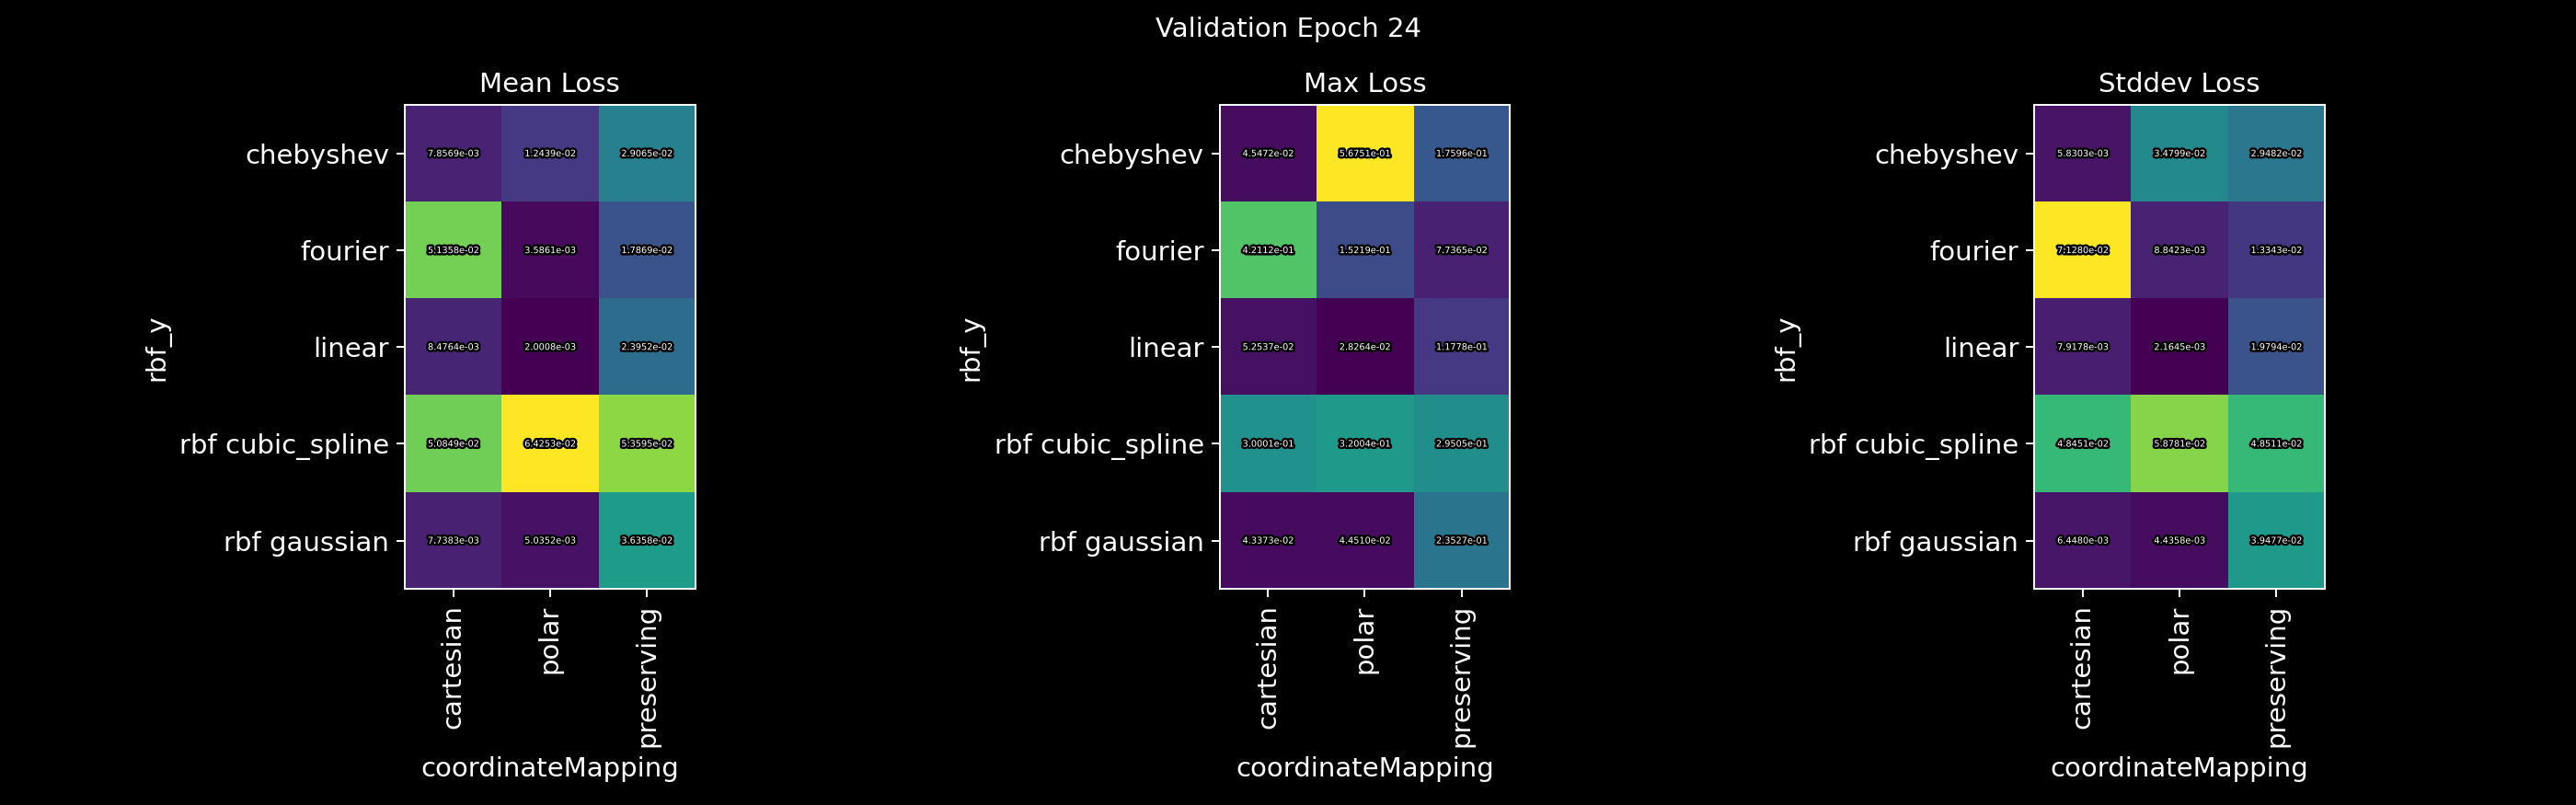

interactive(children=(IntSlider(value=24, description='epoch', max=24), Output()), _dom_classes=('widget-inter…

<function __main__.plot_func(epoch)>

In [90]:
fig, axis = plt.subplots(1, 3, figsize=(16,5), sharex = False, sharey = False, squeeze = False)

epoch = -1

meanLoss = np.ones((len(xvars),len(yvars))) * np.nan
maxLoss = np.ones((len(xvars),len(yvars))) * np.nan
stdDevLoss = np.ones((len(xvars),len(yvars))) * np.nan


for s in subfolders:
    trainingEpochLosses = validationLosses[s]
    overallLosses = np.vstack([np.expand_dims(np.vstack((np.mean(e[:,:,0], axis = 1), np.max(e[:,:,1], axis = 1), np.min(e[:,:,2], axis = 1) , np.mean(e[:,:,3], axis = 1))),2).T for e in trainingEpochLosses])
    
    xv = dataDict[s]['hyperParameters'][which_x]
    yv = dataDict[s]['hyperParameters'][which_y]
    xi = xvars.index(xv)
    yi = yvars.index(yv)
    
    meanLoss[xi,yi] = np.mean(overallLosses[epoch,:,0])
    maxLoss[xi,yi] = np.mean(overallLosses[epoch,:,1])
    stdDevLoss[xi,yi] = np.mean(overallLosses[epoch,:,3])

txtLabels = []


fig.suptitle('Validation')
    
imMean = plotToAxis(axis[0,0], meanLoss, label = 'Mean Loss')
imMax= plotToAxis(axis[0,1], maxLoss, label = 'Max Loss')
imStd = plotToAxis(axis[0,2], stdDevLoss, label = 'Stddev Loss')

fig.tight_layout()

def plot_func(epoch):
    global txtLabels
    meanLoss = np.ones((len(xvars),len(yvars))) * np.nan
    maxLoss = np.ones((len(xvars),len(yvars))) * np.nan
    stdDevLoss = np.ones((len(xvars),len(yvars))) * np.nan


    for s in subfolders:
        trainingEpochLosses = validationLosses[s]
        overallLosses = np.vstack([np.expand_dims(np.vstack((np.mean(e[:,:,0], axis = 1), np.max(e[:,:,1], axis = 1), np.min(e[:,:,2], axis = 1) , np.mean(e[:,:,3], axis = 1))),2).T for e in trainingEpochLosses])

        xv = dataDict[s]['hyperParameters'][which_x]
        yv = dataDict[s]['hyperParameters'][which_y]
        xi = xvars.index(xv)
        yi = yvars.index(yv)

        meanLoss[xi,yi] = np.mean(overallLosses[epoch,:,0])
        maxLoss[xi,yi] = np.mean(overallLosses[epoch,:,1])
        stdDevLoss[xi,yi] = np.mean(overallLosses[epoch,:,3])
    
#     debugPrint(meanLoss.min())
#     debugPrint(meanLoss.max())
    
    imMean.set_clim(vmin=meanLoss[np.logical_not(np.isnan(meanLoss))].min(), vmax=meanLoss[np.logical_not(np.isnan(meanLoss))].max())
    imMax.set_clim(vmin=maxLoss[np.logical_not(np.isnan(meanLoss))].min(), vmax=maxLoss[np.logical_not(np.isnan(meanLoss))].max())
    imStd.set_clim(vmin=stdDevLoss[np.logical_not(np.isnan(meanLoss))].min(), vmax=stdDevLoss[np.logical_not(np.isnan(meanLoss))].max())
    
    imMean.set_data(meanLoss)
    imMax.set_data(maxLoss)
    imStd.set_data(stdDevLoss)
    
    for lbl in txtLabels:
        lbl.remove()
    txtLabels = []
    fig.suptitle('Validation Epoch %d'%epoch)
    
    for (j,i),label in np.ndenumerate(meanLoss):
        if not np.isnan(label):
            st = '%1.4e' % label
            txtLabels.append(axis[0,0].text(i,j,st,ha='center',va='center', color = 'white', fontsize=4, rotation = 0))       
            txtLabels[-1].set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])
    for (j,i),label in np.ndenumerate(maxLoss):
        if not np.isnan(label):
            st = '%1.4e' % label
            txtLabels.append(axis[0,1].text(i,j,st,ha='center',va='center', color = 'white', fontsize=4, rotation = 0))       
            txtLabels[-1].set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])
    for (j,i),label in np.ndenumerate(stdDevLoss):
        if not np.isnan(label):
            st = '%1.4e' % label
            txtLabels.append(axis[0,2].text(i,j,st,ha='center',va='center', color = 'white', fontsize=4, rotation = 0))       
            txtLabels[-1].set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])
            
    fig.canvas.draw_idle()

epochs = dataDict[subfolders[0]]['hyperParameters']['epochs']
interact(plot_func, epoch = widgets.IntSlider(value=epochs -1, min=0, max=epochs -1, step=1))

In [116]:
from densityNet import *
simulationFiles = dataDict[subfolders[0]]['files']
# cutoff = dataDict[subfolders[0]]['hyperParameters']['cutoff']
cutoff = 1800
epochs = dataDict[subfolders[0]]['hyperParameters']['epochs']
try:
    inFile = h5py.File(simulationFiles[0], 'r')
    frameCount = int(len(inFile['simulationExport'].keys()) -1) # adjust for bptcls
    inFile.close()
    debugPrint(frameCount)
    if cutoff < 0:
        cutoff = frameCount - 100
except Exception:
    print('data not available defaulting to 1800')

data not available defaulting to 1800


In [91]:
networks = len(subfolders)
epochs = dataDict[subfolders[0]]['hyperParameters']['epochs']
simulationFiles = dataDict[subfolders[0]]['files']

frameCounts = []

for s in simulationFiles:    
    try:
        inFile = h5py.File(s, 'r')
        frameCount = int(len(inFile['simulationExport'].keys()) -1) # adjust for bptcls
        inFile.close()
        frameCounts.append(frameCount)
    except Exception:
        frameCounts.append(cutoff)

In [92]:
debugPrint(frameCounts)

frameCounts [list] = [1800, 1800]


In [93]:
# def parseSimulationData()

In [94]:
simulationData = []
for s in simulationFiles:    
    try:
        inFile = h5py.File(s, 'r')
        frameCount = int(len(inFile['simulationExport'].keys()) -1) # adjust for bptcls
        inFile.close()
        simulationData.append(np.zeros((len(subfolders), frameCount, epochs, 4))* np.nan) 
    except Exception:
        simulationData.append(np.zeros((len(subfolders), cutoff, epochs, 4))* np.nan) 
# debugPrint(simulationData)

In [95]:
from tqdm.notebook import tqdm

In [96]:
dataDict[subfolders[0]]['dataSet']['training']['00000']

# ['training']).shape

for si, s in tqdm(enumerate(subfolders)):
    trainingDataSet = dataDict[s]['dataSet']['training']
    validationDataSet = dataDict[s]['dataSet']['validation']
    
#     debugPrint(len(trainingDataSet))
    trainingEpochLosses = trainingLosses[s]
    validationEpochLosses = validationLosses[s]
    
    overallTrainingLosses = np.vstack([np.expand_dims(np.vstack((np.mean(e[:,:,0], axis = 1), np.max(e[:,:,1], axis = 1), np.min(e[:,:,2], axis = 1) , np.mean(e[:,:,3], axis = 1))),2).T for e in trainingEpochLosses])
    overallValidationLosses = np.vstack([np.expand_dims(np.vstack((np.mean(e[:,:,0], axis = 1), np.max(e[:,:,1], axis = 1), np.min(e[:,:,2], axis = 1) , np.mean(e[:,:,3], axis = 1))),2).T for e in validationEpochLosses])

#     debugPrint(overallTrainingLosses.shape)
#     debugPrint(overallValidationLosses.shape)
    
    for i in tqdm(range(overallTrainingLosses.shape[1]), leave = False):
        ds = trainingDataSet['%05d' % i]
        file = ds['file']
        frame = ds['t']
        simulationData[simulationFiles.index(file)][si,frame,:] = overallTrainingLosses[:,i,:]
        
    for i in tqdm(range(overallValidationLosses.shape[1]), leave = False):
        ds = validationDataSet['%05d' % i]
        file = ds['file']
        frame = ds['t']
        simulationData[simulationFiles.index(file)][si,frame,:] = overallValidationLosses[:,i,:]
    
    

0it [00:00, ?it/s]

  0%|          | 0/2600 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/2600 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/2600 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/2600 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/2600 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/2600 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/2600 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/2600 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/2600 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/2600 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/2600 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/2600 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/2600 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/2600 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/2600 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


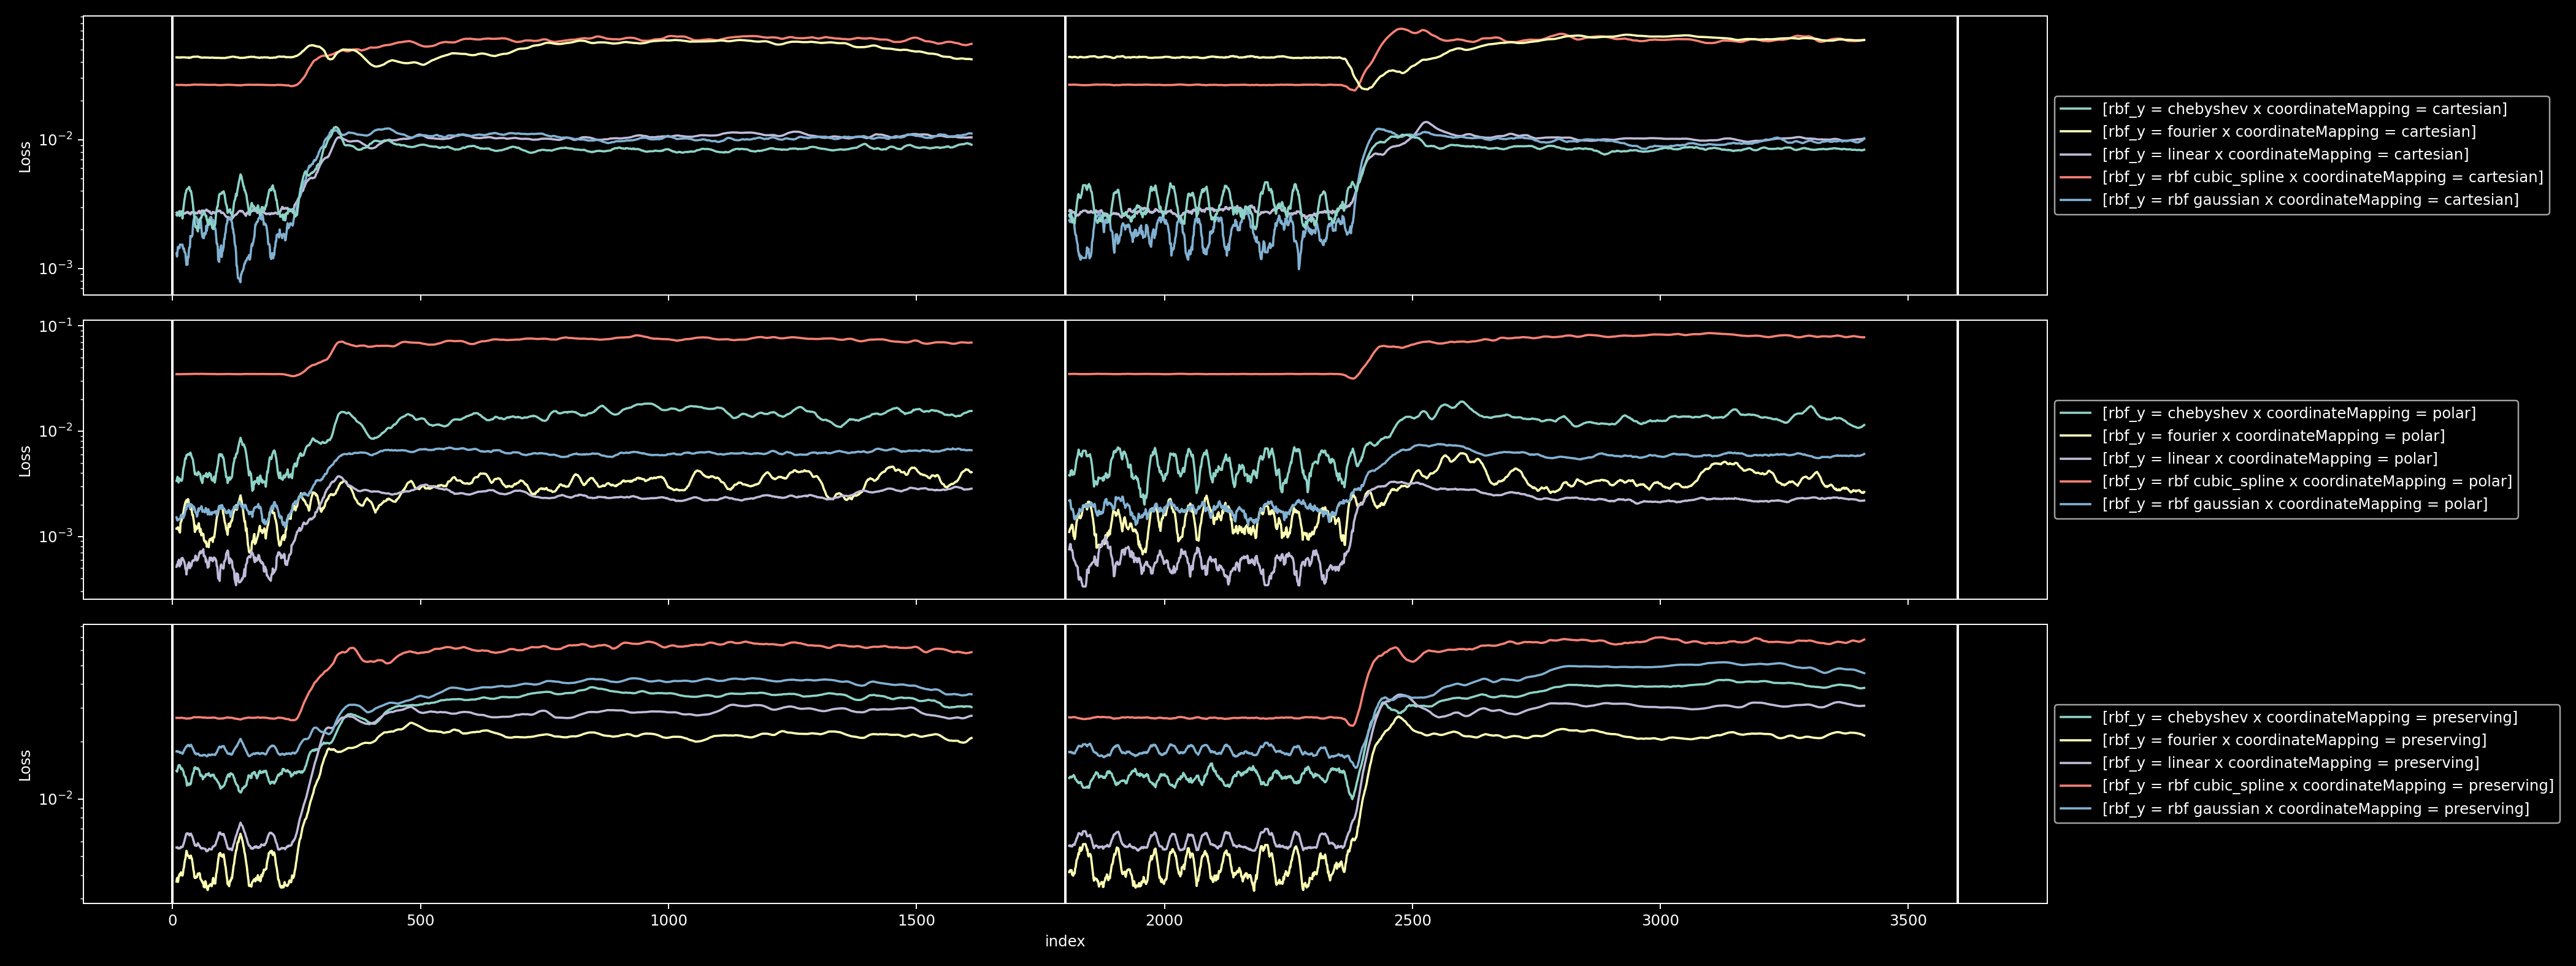

interactive(children=(IntSlider(value=24, description='epoch', max=24), Output()), _dom_classes=('widget-inter…

In [123]:

fig, axis = plt.subplots(len(yvars), 1, figsize=(24,3 * len(yvars)), sharex = True, sharey = False, squeeze = False)

epoch = -1
plotMinMax = False
smoothing = True
window_width = 17

def plotLoss(epoch):
    for i in range(len(yvars)):
        axis[i,0].cla()
        axis[i,0].set_yscale('log')
        axis[i,0].set_ylabel('Loss')

    axis[len(yvars) - 1,0].set_xlabel('index')


    cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for n in range(len(subfolders)):
        for i in range(len(simulationData)):
            begin = 0 if i == 0 else begin + l
            end = begin + np.sum(np.logical_not(np.isnan(simulationData[i][n,:,epoch,0])))
            l = simulationData[i].shape[1]
            
            r = yvars.index(dataDict[subfolders[n]]['hyperParameters'][which_y])
            c = xvars.index(dataDict[subfolders[n]]['hyperParameters'][which_x])

            d = simulationData[i][n,:,epoch,0]
            if smoothing:
                data = d[np.logical_not(np.isnan(d))]
                cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
                data = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
            else:
                data = d[np.logical_not(np.isnan(d))]
            
            axis[r,0].plot(np.arange(begin,end) if not smoothing else np.arange(begin + window_width // 2, end + window_width//2 - window_width + 1), data, c = cols[c % len(cols)], label = '[%s = %s x %s = %s]' % (which_x, dataDict[subfolders[n]]['hyperParameters'][which_x], which_y, dataDict[subfolders[n]]['hyperParameters'][which_y]) if i == 0 else None)
            axis[r,0].axvline(begin + l)
            axis[r,0].axvline(begin)
            if plotMinMax:
                d = simulationData[i][n,:,epoch,1]
                if smoothing:
                    data = d[np.logical_not(np.isnan(d))]
                    cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
                    data = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
                else:
                    data = d[np.logical_not(np.isnan(d))]
                axis[r,0].plot(np.arange(begin,end) if not smoothing else np.arange(begin + window_width // 2, end + window_width//2 - window_width + 1), data, c = cols[c % len(cols)], ls = '--', alpha = 0.5)
                axis[r,0].axvline(begin + l)
                d = simulationData[i][n,:,epoch,2]
                if smoothing:
                    data = d[np.logical_not(np.isnan(d))]
                    cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
                    data = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
                else:
                    data = d[np.logical_not(np.isnan(d))]
                axis[r,0].plot(np.arange(begin,end) if not smoothing else np.arange(begin + window_width // 2, end + window_width//2 - window_width + 1), data, c = cols[c % len(cols)], ls = '--', alpha = 0.5)
                axis[r,0].axvline(begin + l)

    for c in range(len(yvars)):
        axis[c,0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        handles, labels = axis[c,0].get_legend_handles_labels()
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        axis[c,0].legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
#         axis[c,0].grid(which='both', ls = ':', alpha = 0.5, axis = 'y')
    fig.canvas.draw()
    fig.canvas.flush_events()

# plotLoss(0)
    
interact(plotLoss, epoch = widgets.IntSlider(value=epochs - 1, min=0, max=epochs -1, step=1) )

fig.tight_layout()

In [ ]:


fig, axis = plt.subplots(1, 3, figsize=(12,5), sharex = False, sharey = False, squeeze = False)

def loadModel(file, frame, networkPath, epoch):
    n = dataDict[networkPath]['hyperParameters']['n']
    m = dataDict[networkPath]['hyperParameters']['m']
    coordinateMapping = dataDict[networkPath]['hyperParameters']['coordinateMapping']
    windowFn = getWindowFunction(dataDict[networkPath]['hyperParameters']['windowFunction'])
    rbf_x = dataDict[networkPath]['hyperParameters']['rbf_x']
    rbf_y = dataDict[networkPath]['hyperParameters']['rbf_y']
    dist = dataDict[networkPath]['hyperParameters']['frameDistance']
    unroll = dataDict[networkPath]['hyperParameters']['maxRollOut']

    attributes, inputData, groundTruthData = loadFrame(file, frame, 1 + np.arange(unroll), dist)
    fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)
    
    model = DensityNet(fluidFeatures.shape[1], boundaryFeatures.shape[1], coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = 32)
    model.load_state_dict(torch.load('%s/model_%03d.torch' % (networkPath, epoch)))
    model = model.to(device)
    return model
    

model = loadModel(simulationFiles[0], 0, subfolders[0], 0)
n = dataDict[subfolders[0]]['hyperParameters']['n']
m = dataDict[subfolders[0]]['hyperParameters']['m']
coordinateMapping = dataDict[subfolders[0]]['hyperParameters']['coordinateMapping']
windowFn = getWindowFunction(dataDict[subfolders[0]]['hyperParameters']['windowFunction'])
rbf_x = dataDict[subfolders[0]]['hyperParameters']['rbf_x']
rbf_y = dataDict[subfolders[0]]['hyperParameters']['rbf_y']
dist = dataDict[subfolders[0]]['hyperParameters']['frameDistance']
unroll = dataDict[subfolders[0]]['hyperParameters']['maxRollOut']

attributes, inputData, groundTruthData = loadFrame(simulationFiles[0], 0, 1 + np.arange(unroll), dist)
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)

predictedPositions = fluidPositions.to(device)
predictedVelocity = inputData['fluidVelocity'].to(device)

modelOutput = model(fluidPositions.to(device), boundaryPositions.to(device), fluidFeatures.to(device), boundaryFeatures.to(device), attributes, None, None)

gt = groundTruthData[0]

predictedPositions, predictedVelocities = integrateState(attributes, predictedPositions, predictedVelocity, modelOutput)
loss = computeLoss(predictedPositions, predictedVelocities, groundTruthData[0].to(device), modelOutput)



axis[0,0].set_title('prediction')
x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()
v = torch.linalg.norm(modelOutput,dim=1).detach().cpu().numpy()
# debugPrint(v)
predSC = axis[0,0].scatter(x,y,c = v,s=2)
axis[0,0].axis('equal')
axis[0,0].set_xlim(-2.5,2.5)
axis[0,0].set_ylim(-2.5,2.5)
axis[0,0].axvline(-2)
axis[0,0].axvline(2)
axis[0,0].axhline(-2)
axis[0,0].axhline(2)
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")

predCbar = fig.colorbar(predSC, cax=cax1,orientation='horizontal')
predCbar.ax.tick_params(labelsize=8) 


x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()

# v = (gt[:,-1:] - modelOutput) ** 2
v = torch.linalg.norm((gt[:,-1:] ),dim=1)

axis[0,1].set_title('GT')
# sc = axis[1,0].scatter(x,y,c = v,s=0.25)
GTsc = axis[0,1].scatter(x,y,c = v.detach().cpu().numpy(), s= 2)
axis[0,1].axis('equal')
axis[0,1].set_xlim(-2.5,2.5)
axis[0,1].set_ylim(-2.5,2.5)
axis[0,1].axvline(-2)
axis[0,1].axvline(2)
axis[0,1].axhline(-2)
axis[0,1].axhline(2)
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
GTcbar = fig.colorbar(GTsc, cax=cax1,orientation='horizontal')
GTcbar.ax.tick_params(labelsize=8) 

fig.tight_layout()


axis[0,2].set_title('Loss')
# sc = axis[1,0].scatter(x,y,c = v,s=0.25)
lossSC = axis[0,2].scatter(x,y,c = loss.detach().cpu().numpy(), s= 2)
axis[0,2].axis('equal')
axis[0,2].set_xlim(-2.5,2.5)
axis[0,2].set_ylim(-2.5,2.5)
axis[0,2].axvline(-2)
axis[0,2].axvline(2)
axis[0,2].axhline(-2)
axis[0,2].axhline(2)
ax1_divider = make_axes_locatable(axis[0,2])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
lossCbar = fig.colorbar(lossSC, cax=cax1,orientation='horizontal')
lossCbar.ax.tick_params(labelsize=8) 

fig.suptitle('%s @ %2d -\n %s @ %5d' % (subfolders[0], epoch, simulationFiles[0], 0))
    
def plotNetwork(file, frame, networkPath, epoch):
#     axis[0,0].cla()
#     axis[0,1].cla()
#     axis[0,2].cla()
    model = loadModel(file, frame, networkPath, epoch)
    n = dataDict[networkPath]['hyperParameters']['n']
    m = dataDict[networkPath]['hyperParameters']['m']
    coordinateMapping = dataDict[networkPath]['hyperParameters']['coordinateMapping']
    windowFn = getWindowFunction(dataDict[networkPath]['hyperParameters']['windowFunction'])
    rbf_x = dataDict[networkPath]['hyperParameters']['rbf_x']
    rbf_y = dataDict[networkPath]['hyperParameters']['rbf_y']
    dist = dataDict[networkPath]['hyperParameters']['frameDistance']
    unroll = dataDict[networkPath]['hyperParameters']['maxRollOut']
    
    attributes, inputData, groundTruthData = loadFrame(file, frame, 1 + np.arange(unroll), dist)
    fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)


    predictedPositions = fluidPositions.to(device)
    predictedVelocity = fluidFeatures[:,1:3].to(device)

    modelOutput = model(fluidPositions.to(device), boundaryPositions.to(device), fluidFeatures.to(device), boundaryFeatures.to(device), attributes, None, None)

    gt = groundTruthData[0]

    predictedPositions, predictedVelocities = integrateState(attributes, predictedPositions, predictedVelocity, modelOutput)
    loss = computeLoss(predictedPositions, predictedVelocities, groundTruthData[0].to(device), modelOutput)

    data = torch.linalg.norm(modelOutput,dim=1).detach().cpu().numpy()
    positions = fluidPositions.detach().cpu().numpy()
    predSC.set_offsets(positions)
    predSC.set_array(data)
    predCbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
    
    data = torch.linalg.norm((gt[:,-1:] ),dim=1).detach().cpu().numpy()
    debugPrint(data.shape)
    positions = fluidPositions.detach().cpu().numpy()
    GTsc.set_offsets(positions)
    GTsc.set_array(data)
    GTcbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))

    data = loss.detach().cpu().numpy()[:,0]
    positions = fluidPositions.detach().cpu().numpy()
    lossSC.set_offsets(positions)
    lossSC.set_array(data)
    lossCbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
    
    fig.suptitle('%s @ %2d -\n %s @ %5d' % (networkPath, epoch, file, frame))
    fig.canvas.draw()
    fig.canvas.flush_events()



plotNetwork(simulationFiles[0], 0, subfolders[0], epochs - 1)

interact(plotNetwork, file = simulationFiles, frame = widgets.IntSlider(value=0, min=0, max=cutoff -1, step=1), networkPath = subfolders, epoch = widgets.IntSlider(value=epochs -1, min=0, max=epochs -1, step=1), )

fig.tight_layout()

In [10]:
from densityNet import *
simulationFiles = dataDict[subfolders[0]]['files']
# cutoff = dataDict[subfolders[0]]['hyperParameters']['cutoff']
cutoff = 1800
epochs = dataDict[subfolders[0]]['hyperParameters']['epochs']
try:
    inFile = h5py.File(simulationFiles[0], 'r')
    frameCount = int(len(inFile['simulationExport'].keys()) -1) # adjust for bptcls
    inFile.close()
    debugPrint(frameCount)
    if cutoff < 0:
        cutoff = frameCount - 100
except Exception:
    print('data not available defaulting to 1800')

NameError: name 'dataDict' is not defined

simulationFiles [list] = ['../export/collision 0 x 2 - 2023-02-17_15-59-58.hdf5', '../export/collision 5 x 0 - 2023-02-17_16-14-02.hdf5', '../export/collision 0 x 3 - 2023-02-17_16-00-21.hdf5', '../export/collision 4 x 4 - 2023-02-17_16-12-34.hdf5', '../export/collision 3 x 5 - 2023-02-17_16-10-01.hdf5', '../export/collision 4 x 7 - 2023-02-17_16-13-40.hdf5', '../export/collision 6 x 4 - 2023-02-17_16-18-21.hdf5', '../export/collision 5 x 6 - 2023-02-17_16-16-10.hdf5', '../export/collision 1 x 0 - 2023-02-17_16-02-12.hdf5', '../export/collision 1 x 3 - 2023-02-17_16-03-20.hdf5', '../export/collision 0 x 6 - 2023-02-17_16-01-27.hdf5', '../export/collision 4 x 1 - 2023-02-17_16-11-29.hdf5', '../export/collision 4 x 2 - 2023-02-17_16-11-51.hdf5', '../export/collision 0 x 1 - 2023-02-17_15-59-36.hdf5', '../export/collision 0 x 5 - 2023-02-17_16-01-05.hdf5', '../export/collision 6 x 6 - 2023-02-17_16-19-05.hdf5', '../export/collision 5 x 7 - 2023-02-17_16-16-32.hdf5', '../export/collision 2

<IPython.core.display.Javascript object>


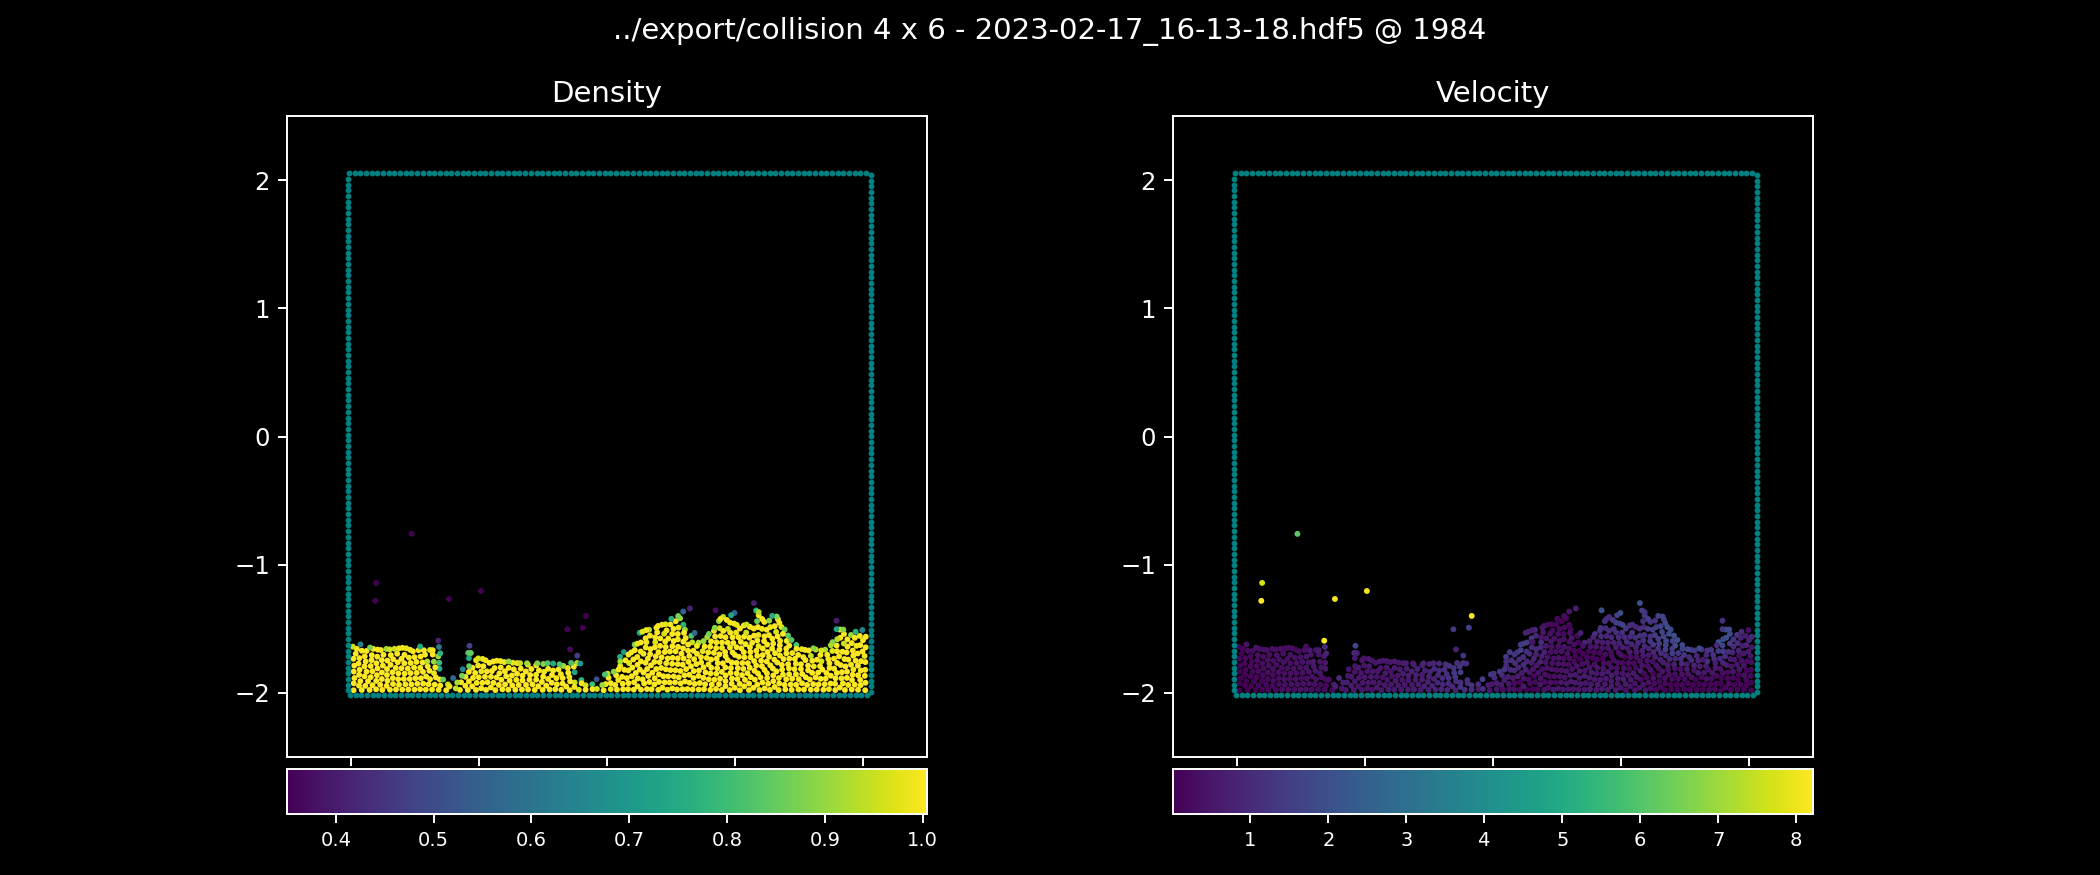

/home/winchenbach/anaconda3/envs/torch_env/lib/python3.9/site-packages/ipykernel/pylab/backend_inline.py:10: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  warnings.warn(


interactive(children=(Dropdown(description='file', options=('../export/collision 0 x 2 - 2023-02-17_15-59-58.h…

In [9]:
basePath = '../export'
basePath = os.path.expanduser(basePath)

simulationFiles = [basePath + '/' + f for f in os.listdir(basePath) if f.endswith('.hdf5')]
debugPrint(simulationFiles)

fig, axis = plt.subplots(1, 2, figsize=(12,5), sharex = False, sharey = False, squeeze = False)

attributes, inputData, groundTruthData = loadFrame(simulationFiles[0], 0, 1 + np.arange(1), 1)

axis[0,0].set_title('Density')
x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()
v = (inputData['fluidDensity']).detach().cpu().numpy()
# debugPrint(v)
predSC = axis[0,0].scatter(x,y,c = v,s=2)
axis[0,0].axis('equal')
axis[0,0].set_xlim(-2.5,2.5)
axis[0,0].set_ylim(-2.5,2.5)
# axis[0,0].axvline(-2)
# axis[0,0].axvline(2)
# axis[0,0].axhline(-2)
# axis[0,0].axhline(2)
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")

axis[0,0].scatter(inputData['boundaryPosition'][:,0], inputData['boundaryPosition'][:,1], c = 'teal', s =2 )

predCbar = fig.colorbar(predSC, cax=cax1,orientation='horizontal')
predCbar.ax.tick_params(labelsize=8) 


x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()

# v = (gt[:,-1:] - modelOutput) ** 2
v = torch.linalg.norm(inputData['fluidVelocity'],dim=1)

axis[0,1].set_title('Velocity')
# sc = axis[1,0].scatter(x,y,c = v,s=0.25)
GTsc = axis[0,1].scatter(x,y,c = v.detach().cpu().numpy(), s= 2)
axis[0,1].axis('equal')
axis[0,1].set_xlim(-2.5,2.5)
axis[0,1].set_ylim(-2.5,2.5)
# axis[0,1].axvline(-2)
# axis[0,1].axvline(2)
# axis[0,1].axhline(-2)
# axis[0,1].axhline(2)
axis[0,1].scatter(inputData['boundaryPosition'][:,0], inputData['boundaryPosition'][:,1], c = 'teal', s =2 )
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
GTcbar = fig.colorbar(GTsc, cax=cax1,orientation='horizontal')
GTcbar.ax.tick_params(labelsize=8) 

fig.tight_layout()

def plotNetwork(file, frame):
    attributes, inputData, groundTruthData = loadFrame(file, frame, 1 + np.arange(1), 1)

    data = inputData['fluidDensity'].detach().cpu().numpy()
    positions = inputData['fluidPosition'].detach().cpu().numpy()
    predSC.set_offsets(positions)
    predSC.set_array(data)
    predCbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
    
    data = torch.linalg.norm(inputData['fluidVelocity'],dim=1).detach().cpu().numpy()
#     debugPrint(data.shape)
    positions = inputData['fluidPosition'].detach().cpu().numpy()
    GTsc.set_offsets(positions)
    GTsc.set_array(data)
    GTcbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))

    fig.suptitle('%s @ %2d' % (file, frame))
    fig.canvas.draw()
    fig.canvas.flush_events()



# plotNetwork(simulationFiles[0], 0, subfolders[0], epochs - 1)

interact(plotNetwork, file = simulationFiles, frame = widgets.IntSlider(value=0, min=0, max=2000 -1, step=1))

fig.tight_layout()



In [12]:
from tqdm.notebook import tqdm

In [16]:
import subprocess
import shlex

simulationFile = simulationFiles[0]

for simulationFile in tqdm(simulationFiles):
    inFile = h5py.File(simulationFile, 'r')
    frameCount = int(len(inFile['simulationExport'].keys()) -1) # adjust for bptcls
    inFile.close()

    imageFolder = '../images/%s/' % simulationFile.split('/')[-1].split('.')[0]
    if not os.path.exists(imageFolder):
        os.makedirs(imageFolder)
        for i in tqdm(range(0, frameCount, 16), leave = False):
            plotNetwork(simulationFile, i)
            imagePath = '../images/%s/%04d.png' % (simulationFile.split('/')[-1].split('.')[0], i)
            plt.savefig(imagePath, dpi = 200)
#         print('Creating video file')
        p = subprocess.Popen(shlex.split("/usr/bin/ffmpeg -y -hide_banner -loglevel error -framerate 60 -f image2 -pattern_type glob -i '*.png' -c:v libx264 -b:v 20M -r 60 out.mp4"), cwd='../images/%s/' % simulationFile.split('/')[-1].split('.')[0])
        p.wait()
#         print('Creating video gif')
        p = subprocess.Popen(shlex.split("/usr/bin/ffmpeg -y -hide_banner -loglevel error -i out.mp4 -filter_complex 'fps=60,scale=720:-1:flags=lanczos,split[s0][s1];[s0]palettegen=max_colors=32[p];[s1][p]paletteuse=dither=bayer' output.gif"), cwd='../images/%s/' % simulationFile.split('/')[-1].split('.')[0])
        p.wait()
#         print('Copying output')
        p = subprocess.Popen(shlex.split('cp output.gif ../%s.gif' % ' '.join(simulationFile.split('/')[-1].split(' ')[:-2]).replace(' ','_')), cwd = '../images/%s/' % simulationFile.split('/')[-1].split('.')[0])
        p.wait()
    else:
        print('nothing to do for %s' % simulationFile)


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

In [15]:
import subprocess
import shlex


In [27]:
import subprocess
import shlex

simulationFile = simulationFiles[0]

for simulationFile in tqdm(simulationFiles):
    inFile = h5py.File(simulationFile, 'r')
    frameCount = int(len(inFile['simulationExport'].keys()) -1) # adjust for bptcls
    inFile.close()

    imageFolder = '../images/%s/' % simulationFile.split('/')[-1].split('.')[0]
    p = subprocess.Popen(shlex.split('cp output.gif ../%s.gif' % ' '.join(simulationFile.split('/')[-1].split(' ')[:-2]).replace(' ','_')), cwd = '../images/%s/' % simulationFile.split('/')[-1].split('.')[0])
    p.wait()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 47.36it/s]


In [19]:
shlex.split(' '.join('cp output.gif ../%s.gif' % simulationFiles[0].split('/')[-1].split(' ')[:-2]).split('.')[0].replace(' ', '_'))

['c_p___o_u_t_p_u_t_']

In [25]:
('cp output.gif ../%s.gif' % ' '.join(simulationFiles[0].split('/')[-1].split(' ')[:-2]).replace(' ','_'))

'cp output.gif ../collision_2_x_1.gif'